# MNIST Digits Classifier

1️⃣ *Load Libraries*

In [87]:
import numpy as np
from matplotlib import pyplot as plt
from typing import Tuple

2️⃣ *Load and Preprocess Dataset*

*We load the MNIST dataset from the official NumPy archive (mnist.npz), which contains pre-split training and test sets. Each image is a 28×28 grayscale digit that is flattened into a 784-dimensional vector. Pixel values are normalized by dividing by 255. The training set is used to learn model parameters, while the test set serves as the development set for evaluation.*

In [88]:
data = np.load("Dataset/mnist.npz")

X_train: np.ndarray = data["x_train"].reshape(-1, 28*28).T / 255.0
Y_train: np.ndarray = data["y_train"]

X_dev: np.ndarray = data["x_test"].reshape(-1, 28*28).T / 255.0
Y_dev: np.ndarray = data["y_test"]

_, m_train = X_train.shape


In [89]:
Y_train

array([5, 0, 4, ..., 5, 6, 8], shape=(60000,), dtype=uint8)

3️⃣ *Initialize Parameters and Define Activations*


- *Randomly initialize weights and biases.*

- *Hidden layer uses ReLU activation.*

- *Output layer uses softmax to get probability distribution over digits.*

In [90]:
def init_params() -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    W1: np.ndarray = np.random.rand(10, 784) - 0.5
    b1: np.ndarray = np.random.rand(10, 1) - 0.5
    W2: np.ndarray = np.random.rand(10, 10) - 0.5
    b2: np.ndarray = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2


def ReLU(Z: np.ndarray) -> np.ndarray:
    return np.maximum(Z, 0)


def softmax(Z: np.ndarray) -> np.ndarray:
    expZ = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    return expZ / np.sum(expZ, axis=0, keepdims=True)


4️⃣ *Forward Propagation*
$$
Z^{[1]} = W^{[1]} X + b^{[1]}, \quad
A^{[1]} = \text{ReLU}(Z^{[1]})
$$

$$
Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}, \quad
A^{[2]} = \text{softmax}(Z^{[2]})
$$


In [91]:
def forward_prop(W1: np.ndarray, b1: np.ndarray,
                 W2: np.ndarray, b2: np.ndarray,
                 X: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    Z1: np.ndarray = W1.dot(X) + b1
    A1: np.ndarray = ReLU(Z1)
    Z2: np.ndarray = W2.dot(A1) + b2
    A2: np.ndarray = softmax(Z2)
    return Z1, A1, Z2, A2

5️⃣ *Backward Propagation*

$$
dZ^{[2]} = A^{[2]} - Y
$$

$$
dW^{[2]} = \frac{1}{m} dZ^{[2]} (A^{[1]})^\top, \quad
db^{[2]} = \frac{1}{m} \sum_{i=1}^{m} dZ^{[2](i)}
$$

$$
dZ^{[1]} = (W^{[2]})^\top dZ^{[2]} \odot \text{ReLU}'(Z^{[1]})
$$

$$
dW^{[1]} = \frac{1}{m} dZ^{[1]} X^\top, \quad
db^{[1]} = \frac{1}{m} \sum_{i=1}^{m} dZ^{[1](i)}
$$


In [92]:
def ReLU_deriv(Z: np.ndarray) -> np.ndarray:
    return Z > 0


def one_hot(Y: np.ndarray) -> np.ndarray:
    one_hot_Y: np.ndarray = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    return one_hot_Y.T


def backward_prop(Z1: np.ndarray, A1: np.ndarray,
                  Z2: np.ndarray, A2: np.ndarray,
                  W1: np.ndarray, W2: np.ndarray,
                  X: np.ndarray, Y: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    m: int = X.shape[1]
    one_hot_Y: np.ndarray = one_hot(Y)
    dZ2: np.ndarray = A2 - one_hot_Y
    dW2: np.ndarray = 1 / m * dZ2.dot(A1.T)
    db2: np.ndarray = 1 / m * np.sum(dZ2, axis=1, keepdims=True)
    dZ1: np.ndarray = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1: np.ndarray = 1 / m * dZ1.dot(X.T)
    db1: np.ndarray = 1 / m * np.sum(dZ1, axis=1, keepdims=True)
    return dW1, db1, dW2, db2

6️⃣ *Update Parameters*

$$
W^{[1]} := W^{[1]} - \alpha dW^{[1]}, \quad
b^{[1]} := b^{[1]} - \alpha db^{[1]}
$$

$$
W^{[2]} := W^{[2]} - \alpha dW^{[2]}, \quad
b^{[2]} := b^{[2]} - \alpha db^{[2]}
$$


In [93]:
def update_params(W1: np.ndarray, b1: np.ndarray,
                  W2: np.ndarray, b2: np.ndarray,
                  dW1: np.ndarray, db1: np.ndarray,
                  dW2: np.ndarray, db2: np.ndarray,
                  alpha: float) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    return W1, b1, W2, b2

7️⃣ *Predictions and Accuracy*

In [94]:
def get_predictions(A2: np.ndarray) -> np.ndarray:
    return np.argmax(A2, axis=0)


def get_accuracy(predictions: np.ndarray, Y: np.ndarray) -> float:
    return np.sum(predictions == Y) / Y.size



8️⃣ *Gradient Descent Training*

In [95]:

def gradient_descent(X: np.ndarray, Y: np.ndarray,
                     alpha: float, iterations: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 10 == 0:
            print("Iteration:", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
    return W1, b1, W2, b2


W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.10, 500)


Iteration: 0
0.0895
Iteration: 10
0.24098333333333333
Iteration: 20
0.35495
Iteration: 30
0.42005
Iteration: 40
0.4704833333333333
Iteration: 50
0.5139166666666667
Iteration: 60
0.55
Iteration: 70
0.5798666666666666
Iteration: 80
0.6056166666666667
Iteration: 90
0.6269
Iteration: 100
0.64635
Iteration: 110
0.6630166666666667
Iteration: 120
0.6779166666666666
Iteration: 130
0.69105
Iteration: 140
0.7021166666666666
Iteration: 150
0.7118666666666666
Iteration: 160
0.7207166666666667
Iteration: 170
0.7284
Iteration: 180
0.7352333333333333
Iteration: 190
0.74205
Iteration: 200
0.7485333333333334
Iteration: 210
0.7548666666666667
Iteration: 220
0.7607666666666667
Iteration: 230
0.7658833333333334
Iteration: 240
0.77105
Iteration: 250
0.7763
Iteration: 260
0.7806
Iteration: 270
0.7849833333333334
Iteration: 280
0.7893333333333333
Iteration: 290
0.7932333333333333
Iteration: 300
0.7974
Iteration: 310
0.8005833333333333
Iteration: 320
0.8045166666666667
Iteration: 330
0.8077166666666666
Iterat

9️⃣ *Visualize Predictions*

Prediction: [3]
Label: 5


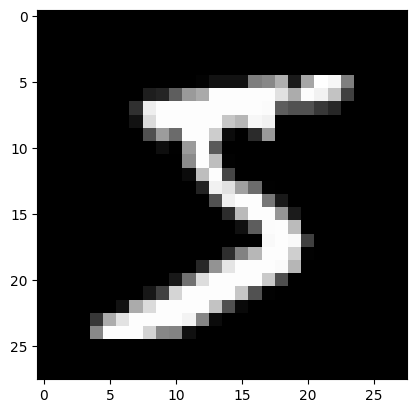

Prediction: [0]
Label: 0


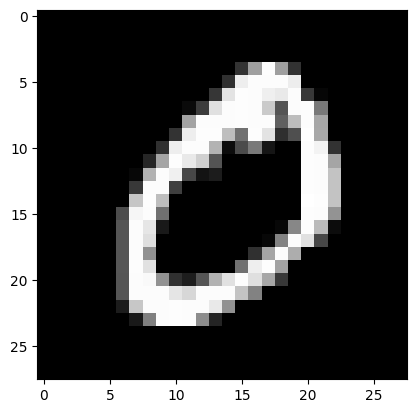

Prediction: [3]
Label: 4


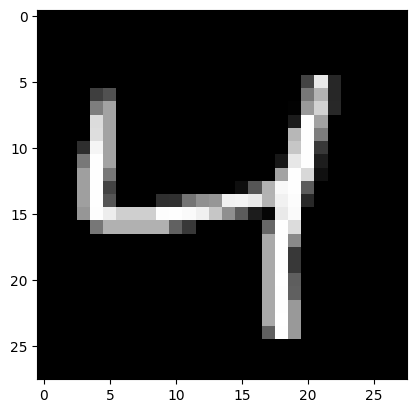

Prediction: [1]
Label: 1


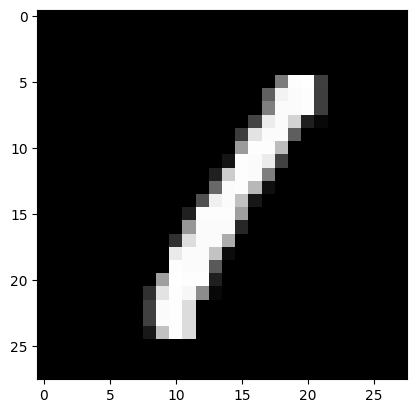

Prediction: [9]
Label: 9


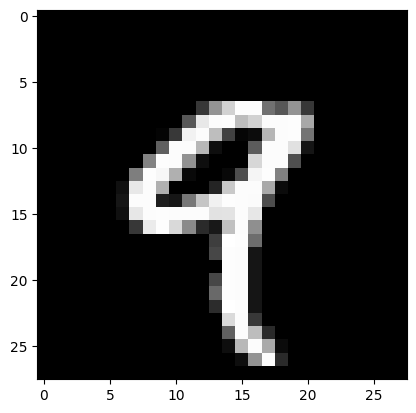

Prediction: [2]
Label: 2


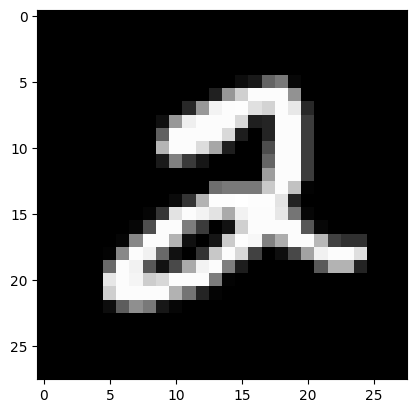

Prediction: [1]
Label: 1


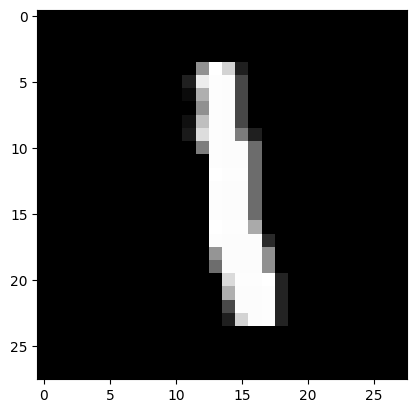

Prediction: [3]
Label: 3


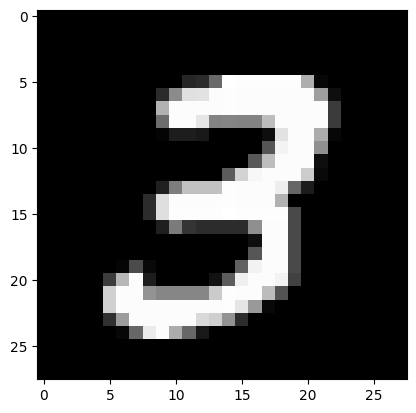

Prediction: [1]
Label: 1


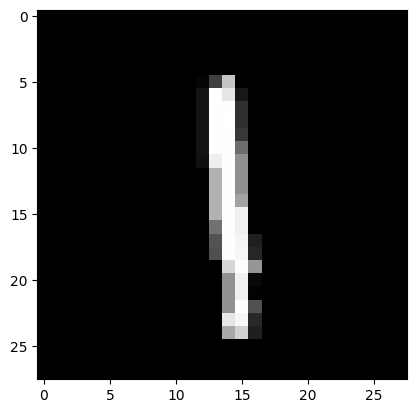

Prediction: [4]
Label: 4


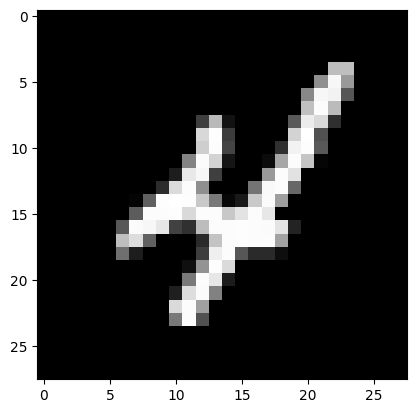

In [96]:
def make_predictions(X: np.ndarray,
                     W1: np.ndarray, b1: np.ndarray,
                     W2: np.ndarray, b2: np.ndarray) -> np.ndarray:
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    return get_predictions(A2)


def test_prediction(index: int,
                    W1: np.ndarray, b1: np.ndarray,
                    W2: np.ndarray, b2: np.ndarray) -> None:
    current_image: np.ndarray = X_train[:, index, None]
    prediction: np.ndarray = make_predictions(current_image, W1, b1, W2, b2)
    label: int = int(Y_train[index])
    print("Prediction:", prediction)
    print("Label:", label)

    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()


for i in range(10):
    test_prediction(i, W1, b1, W2, b2)

🔟 *Evaluate on Development Set*

In [97]:
dev_predictions: np.ndarray = make_predictions(X_dev, W1, b1, W2, b2)
accuracy: float = get_accuracy(dev_predictions, Y_dev)
print(f"Dev set accuracy: {accuracy:.4f}")

Dev set accuracy: 0.8509
